In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from rnn_coach.src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import pickle
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [2]:
task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [3]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [4]:
len(RNNs)

428

In [5]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
for folder in RNNs:
    day = float(datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d'))
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    if (month == '05') and (day >=18):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)

In [6]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [7]:
# additional filtering
df = df[df['lr'] == 0.002]
df = df[df['maxiter'] == 3000]

In [8]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,activation,lmbdo,lmbdr,lr,maxiter
77,0.0064935_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.05;...,0.006494,94,relu,0.3,0.05,0.002,3000
9,0.006521_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;l...,0.006521,99,relu,0.3,0.05,0.002,3000
40,0.0065541_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006554,99,relu,0.3,0.05,0.002,3000
13,0.0065775_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.05;...,0.006578,96,relu,0.3,0.05,0.002,3000
82,0.0065778_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006578,99,relu,0.3,0.05,0.002,3000
10,0.0066179_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006618,99,relu,0.3,0.05,0.002,3000
47,0.0066384_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;...,0.006638,98,relu,0.3,0.05,0.002,3000
43,0.0066552_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006655,99,relu,0.3,0.05,0.002,3000
96,0.0066878_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;...,0.006688,98,relu,0.3,0.05,0.002,3000
62,0.0067282_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;...,0.006728,97,relu,0.3,0.05,0.002,3000


In [9]:
top_RNNs = df.sort_values("scores")["name"].tolist()[:50]

In [10]:
top_RNNs

['0.0064935_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.006521_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0065541_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0065775_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0065778_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0066179_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0066384_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0066552_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0066878_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0067282_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0067343_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0067382_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0067717_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0067853_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=

In [12]:
Qs = []
for num_rnn in range(len(top_RNNs)):
    RNN_subfolder = top_RNNs[num_rnn]
    RNN_score = float(top_RNNs[num_rnn].split("_")[0])
    RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
    LA_data = pickle.load(open(os.path.join(RNN_path, f"{RNN_score}_LA_data.pkl"), "rb+"))
    LC_folder = RNN_subfolder
    RNN_score = float(RNN_subfolder.split("_")[0])
    RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDMplus", RNN_subfolder)
    LC_folder_path = os.path.join('../', '../', "latent_circuit_inference", "data", "inferred_LCs", LC_folder)
    subfolders = os.listdir(LC_folder_path)
    varianses = []
    variances_pr = []
    names = []
    for i, subfolder in enumerate(subfolders):
        if "8nodes" in subfolder or "8-nodes" in subfolder:
            score = float(subfolder.split("_")[0])
            score_pr = float(subfolder.split("_")[1])
            varianses.append(score)
            variances_pr.append(score_pr)
            names.append(subfolder)
    lc_df = pd.DataFrame({"name" : names, "variance" : varianses, "variance_pr" : variances_pr})
    top_LCs = lc_df.sort_values("variance", ascending=False)["name"].tolist()
    LC_subfolder = top_LCs[0]
    print(LC_subfolder)
    score = float(LC_subfolder.split("_")[0])
    score_pr = float(LC_subfolder.split("_")[1])
    LC_path = os.path.join(LC_folder_path, LC_subfolder)
    LC_data = json.load(open(os.path.join(LC_path, f"{score}_{score_pr}_LC_params.json"), "rb+"))
    U = np.array(LC_data["U"])
    q = np.array(LC_data["q"])
    Q = U.T @ q
    w_out = np.array(LC_data["W_out"])
    w_rec = np.array(LC_data["W_rec"])
    w_inp = np.array(LC_data["W_inp"])
    N = LC_data["N"]
    dt = LC_data["dt"]
    tau = LC_data["tau"]
    Qs.append(deepcopy(Q))

0.9208512448539508_0.9659069281606291_LC_8nodes;encoding
0.8968820482834975_0.9556853810722444_LC_8nodes;encoding
0.9177196060699941_0.9592328897250156_LC_8nodes;encoding
0.8947227153073066_0.9450215562139024_LC_8nodes;encoding
0.9183798424611566_0.9640060594396805_LC_8nodes;encoding
0.9090389377854542_0.9613314326894814_LC_8nodes;encoding
0.8978929792253506_0.9532368770429807_LC_8nodes;encoding
0.9053327348416085_0.9534486072709892_LC_8nodes;encoding
0.9143811063520209_0.9666959980850063_LC_8nodes;encoding
0.8915207335310602_0.9333250609060401_LC_8nodes;encoding
0.8950246522496724_0.9504307558138884_LC_8nodes;encoding
0.9063177236687263_0.9564047549703301_LC_8nodes;encoding
0.9169266202437187_0.967721945220999_LC_8nodes;encoding
0.9088084653492474_0.9635196842378206_LC_8nodes;encoding
0.8928993983097108_0.9441247089876798_LC_8nodes;encoding
0.9174125706039069_0.9601606702182837_LC_8nodes;encoding
0.9007423787374299_0.9546712084509007_LC_8nodes;encoding
0.9180881729570158_0.97167015545

In [14]:
Q_features = np.vstack(Qs)

In [ ]:
Q_0

In [18]:
pca = PCA(n_components=2)
pca.fit(Q_features)
Q_projected = Q_features @ pca.components_.T

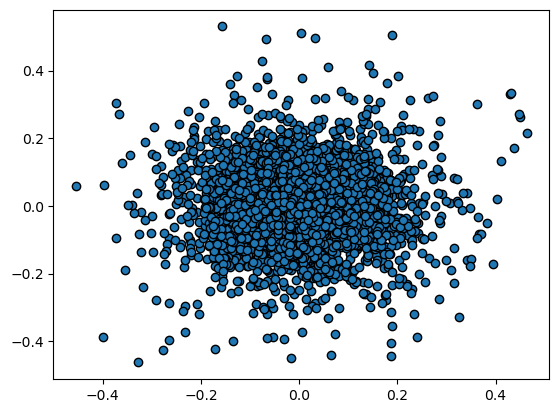

In [21]:
plt.scatter(Q_projected[:, 0], Q_projected[:, 1], edgecolors='k')